In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from sir_model import *

Set parameters for the SIR model

In [2]:
t_0 = 0
t_end = 10000
NT = t_end - t_0

# tolerance parameters used in solve_ivp
# if these error tolerances are set too high, the solution will be qualitatively (!) wrong
rtol = 1e-8
atol = 1e-8

# SIR model parameters
# we want to make beta the changeable variable so we do not define beta here
A = 20
d = 0.1
nu = 1
b = 0.02  
mu0 = 10  
mu1 = 10.45  


In this notebook we want to see the saddle-node bifurcation, where two endemic equiliria merge and annihilate each other. So we create an object called endemic_equilibrium that takes SIR model parameters as input and calculate the variables that will be used later.

In [3]:
class endemic_equilibrium:
    """
    A class to calculate the endemic equilibrium state of an SIR model 
    based on a quadratic equation for the infectious population.

    This class determines the equilibrium values for the susceptible (S) and 
    recovered (R) populations, as well as other variables derived from a given 
    set of epidemiological parameters and conditions.

    Parameters:
    ----------
    beta : float or ndarray
        The average number, or an array of the average numbers of adequate contacts
        per unit time with infectious individuals.
    
    tol : float, optional
        The discriminant (`delta0`) is adjusted to zero if it is negative and its abolute value falls below `tol`, 
        allowing for numerical stability in root calculations. (default is 1e-10).

    All the other parameters should be of type float, and their meanings are the same as in the exercise sheet.

    Attributes:
    ----------
    AA, BB, CC: float
        Coefficients of the quadratic function
    delta0 : float or ndarray
        Discriminant of the quadratic equation. Adjusted for numerical stability.
    I1, I2 : float or ndarray
        First and second root of the quadratic equation representing infectious population.
    I : ndarray
        Array of [I1, I2].
    mu_b_I1, mu_b_I2 : float or ndarray
        Per capita recovery rate of infectious individuals, at the first and second infectious equilibrium.
    mu_b_I : ndarray
        Array of [mu_b_I1, mu_b_I2].
    S_equi : ndarray
        Equilibrium values for the susceptible population corresponding to I1 and I2.
    R_equi : ndarray
        Equilibrium values for the recovered population corresponding to I1 and I2.
    
    Note:
    ------
    - We can ignore the error "RuntimeWarning: invalid value encountered in sqrt" when using this class,
    because this error occurs when delta0 < 0, and it will make the corresponding I values be Nan and thus
    when we plot I values against beta values, these invalid I values will not appear in the plot.
    """

    def __init__(self, beta, A, d, nu, b, mu0, mu1, tol = 1e-10):
        # parameters of the quadratic equation to get the endemic I values
        self.AA = (d+nu+mu0) * (beta-nu)
        self.BB = (d+nu+mu0-beta)*A + (beta-nu)*(d+nu+mu1)*b
        self.CC = (d+nu+mu1)*A*b*(1-R0(beta, d, nu, mu1))
        self.delta0 = self.BB**2 - 4*self.AA*self.CC
        self.delta0 = np.where((self.delta0 < 0) & (np.abs(self.delta0) < tol), 0, self.delta0)  # implement tolerance

        # the roots of the quadratic equation
        self.I1 = (-self.BB - np.sqrt(self.delta0)) / (2*self.AA)
        self.I2 = (-self.BB + np.sqrt(self.delta0)) / (2*self.AA)
        self.I = np.array([self.I1, self.I2])

        # calculation of mu(b,I)
        self.mu_b_I1 = mu0 + (mu1-mu0)*b/(b+self.I1)
        self.mu_b_I2 = mu0 + (mu1-mu0)*b/(b+self.I2)
        self.mu_b_I = np.array([self.mu_b_I1, self.mu_b_I2])

        # endemic equilibrium
        self.S_equi = (A - (d+nu+self.mu_b_I)*self.I) / d
        self.R_equi = self.mu_b_I*self.I/d

Plot delta0 against beta to see the roots

C:\Users\lenovo\AppData\Local\Temp\ipykernel_24168\2706334120.py:57: RuntimeWarning: invalid value encountered in sqrt
  self.I1 = (-self.BB - np.sqrt(self.delta0)) / (2*self.AA)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_24168\2706334120.py:58: RuntimeWarning: invalid value encountered in sqrt
  self.I2 = (-self.BB + np.sqrt(self.delta0)) / (2*self.AA)


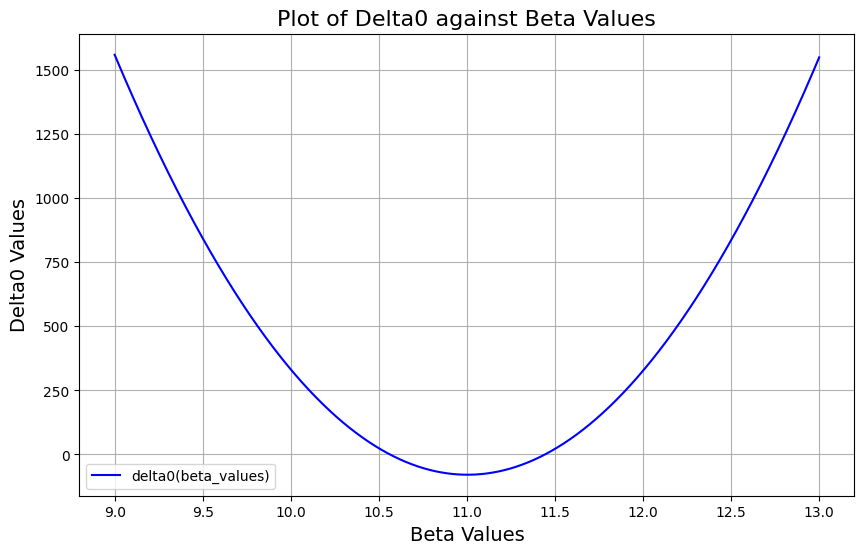

In [4]:
plot_resolution = 1e-5
beta_values = np.arange(9, 13, plot_resolution)
ee = endemic_equilibrium(beta_values, A, d, nu, b, mu0, mu1)
delta0_values = ee.delta0

# plot delta0_values against beta_values
plt.figure(figsize=(10, 6))
plt.plot(beta_values, delta0_values, label="delta0(beta_values)", color="blue")
plt.xlabel("Beta Values", fontsize=14)
plt.ylabel("Delta0 Values", fontsize=14)
plt.title("Plot of Delta0 against Beta Values", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

# ignore the error "RuntimeWarning: invalid value encountered in sqrt", because this error occurs when delta0 < 0, 
# and it will make the corresponding I values be Nan and thus when we plot I values against beta values, 
# these invalid I values will not appear in the plot

In [5]:
# graph solution
beta_at_delta0_is_zero = np.sort(beta_values[np.argsort(np.abs(delta0_values))[:2]])
print(f"at delta0 = 0, beta is {beta_at_delta0_is_zero}")

at delta0 = 0, beta is [10.56313 11.44318]


Plot I values against beta values

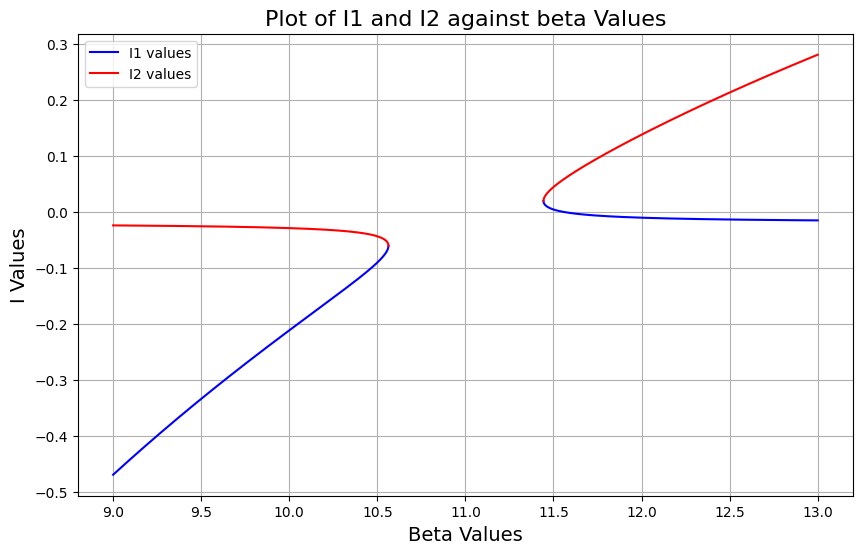

In [6]:
I1_values, I2_values = ee.I

plt.figure(figsize=(10, 6))
plt.plot(beta_values, I1_values, label="I1 values", color="blue")
plt.plot(beta_values, I2_values, label="I2 values", color="red")
# Add labels, title, and legend
plt.xlabel("Beta Values", fontsize=14)
plt.ylabel("I Values", fontsize=14)
plt.title("Plot of I1 and I2 against beta Values", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

Analyze the result of the plots above

In [7]:
# We can't reach I<0 for sure, so we only check the beta on the right side
beta_bifur = round(beta_at_delta0_is_zero[1], 5)
print(f"a bifurcation will happen around beta = {beta_bifur} ")

a bifurcation will happen around beta = 11.44318 


Create two initial conditions that correspond to the two endemic equilibria at beta_test to see which I value corresponds to a stable equilibrium

In [8]:
beta_test = 11.5
print(f"R0 at beta_test = {beta_test} is {round(R0(beta_test, d, nu, mu1), 5)} \nR0 < 1 is {R0(beta_test, d, nu, mu1) < 1}")
print(f"beta_test > d+nu+mu0 is {beta_test > d+nu+mu0}")

ee_test = endemic_equilibrium(beta_test, A, d, nu, b, mu0, mu1)
print(f"BB < 0 is {ee_test.BB < 0}")
S1_test, S2_test = ee_test.S_equi
I1_test, I2_test = ee_test.I
R1_test, R2_test = ee_test.R_equi

test_scenes_init_cond = np.array([[S1_test, I1_test, R1_test],
                                  [S2_test, I2_test, R2_test]])

dS_dt_init = A - d*ee_test.S_equi - (beta_test*ee_test.S_equi*ee_test.I)/(ee_test.S_equi+ee_test.I+ee_test.R_equi)

with np.printoptions(precision=5, suppress=True):
    print(f"initial conditions in test scene is \n {np.round(test_scenes_init_cond, 5)}")
print(f"dS/dt at initial conditions are {dS_dt_init}")
print(f"dS/dt == 0 is {dS_dt_init < 1e-10} numerically with tolerance {1e-10}")

R0 at beta_test = 11.5 is 0.99567 
R0 < 1 is True
beta_test > d+nu+mu0 is True
BB < 0 is True
initial conditions in test scene is 
 [[199.55163   0.00391   0.4054 ]
 [195.06278   0.04392   4.45408]]
dS/dt at initial conditions are [ 1.62370117e-15 -8.88178420e-16]
dS/dt == 0 is [ True  True] numerically with tolerance 1e-10


Plot the S against I and see their development as time elapses

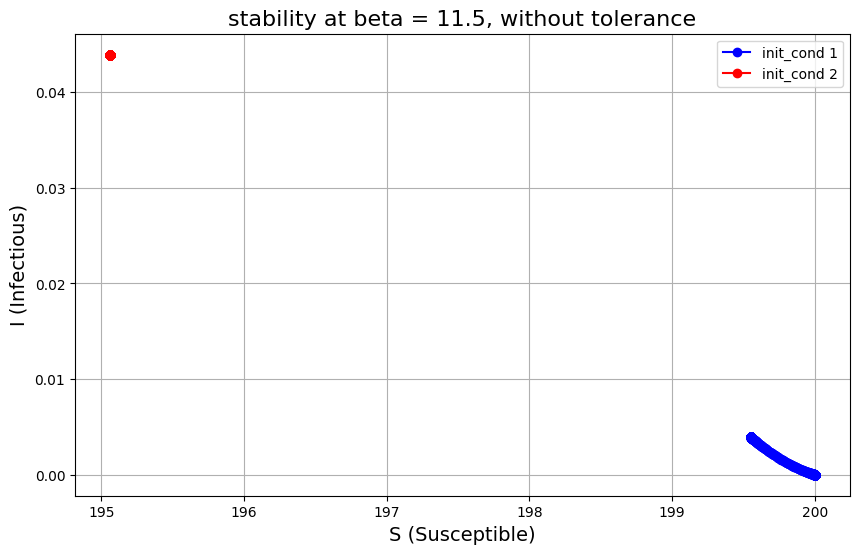

In [9]:
time = np.linspace(t_0, t_end, NT)

cond1, cond2 = test_scenes_init_cond[0], test_scenes_init_cond[1]

sol_I1 = solve_ivp(model, t_span=[time[0], time[-1]], y0=cond1, t_eval=time, args=(mu0, mu1, beta_test, A, d, nu, b),
                method="LSODA", rtol=rtol, atol=atol)
sol_I2 = solve_ivp(model, t_span=[time[0], time[-1]], y0=cond2, t_eval=time, args=(mu0, mu1, beta_test, A, d, nu, b),
                method="LSODA", rtol=rtol, atol=atol)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(sol_I1.y[0], sol_I1.y[1], label="init_cond 1", color="blue", marker = "o")
plt.plot(sol_I2.y[0], sol_I2.y[1], label="init_cond 2", color="red", marker = "o")
plt.xlabel("S (Susceptible)", fontsize=14)
plt.ylabel("I (Infectious)", fontsize=14)
plt.title(f"stability at beta = {beta_test}, without tolerance", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()



Introduce tolerance model to counter the instability of the unstable endemic equilibrium and see what happens as beta approaches the right zero point of delta0. 

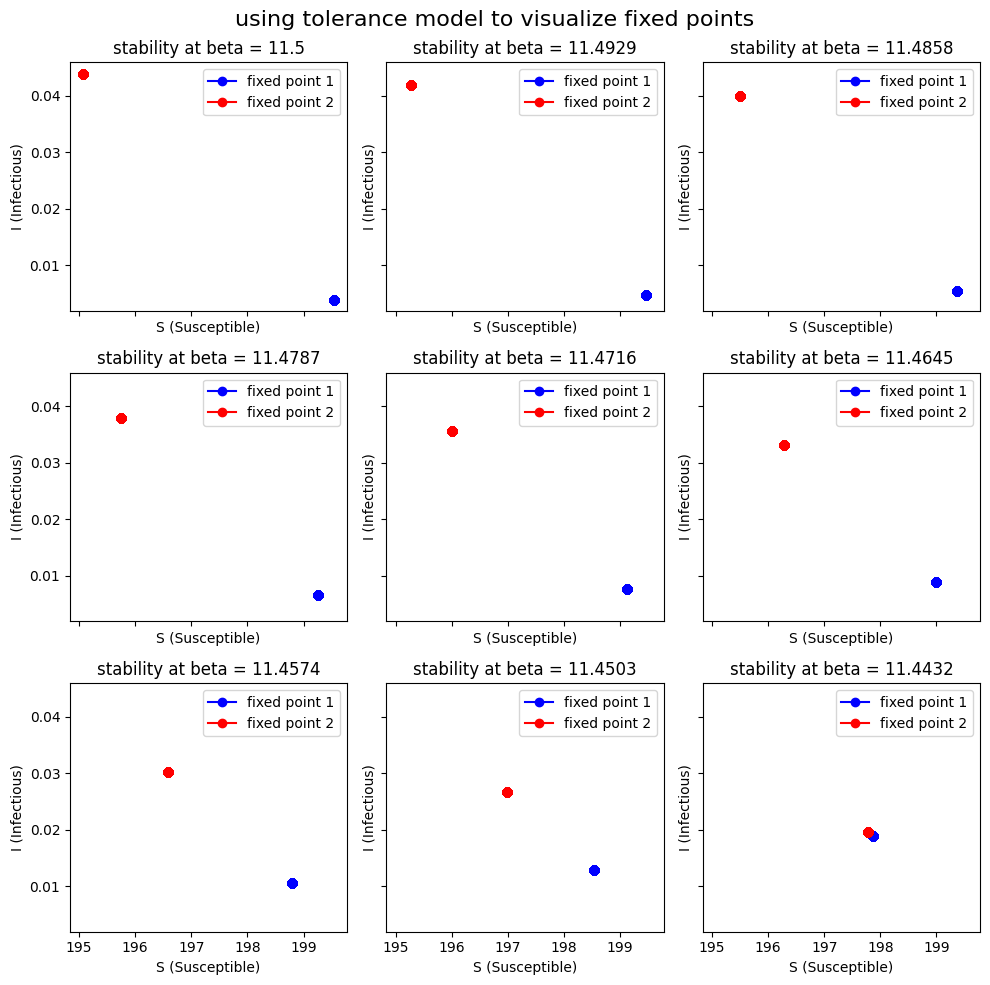

In [10]:
# now we see initial condition 2 is a stable fixed point, while initial condition 1 is not a stable fixed point

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(10, 10), sharex=True, sharey=True)
beta_plot_range = np.linspace(11.5, 11.4432, 9)
for i, beta in enumerate(beta_plot_range.tolist()):
    ee_plot = endemic_equilibrium(beta, A, d, nu, b, mu0, mu1)
    S1_plot, S2_plot = ee_plot.S_equi
    I1_plot, I2_plot = ee_plot.I
    R1_plot, R2_plot = ee_plot.R_equi

    plot_scenes_init_cond = np.array([[S1_plot, I1_plot, R1_plot],
                                  [S2_plot, I2_plot, R2_plot]])
    cond1, cond2 = plot_scenes_init_cond[0], plot_scenes_init_cond[1]

    sol_I1 = solve_ivp(model_with_tolerance, t_span=[time[0], time[-1]], y0=cond1, t_eval=time, args=(mu0, mu1, beta, A, d, nu, b),
                    method="LSODA", rtol=rtol, atol=atol)
    sol_I2 = solve_ivp(model_with_tolerance, t_span=[time[0], time[-1]], y0=cond2, t_eval=time, args=(mu0, mu1, beta, A, d, nu, b),
                    method="LSODA", rtol=rtol, atol=atol)

    ax = axes[i//3, i%3]
    
    ax.plot(sol_I1.y[0], sol_I1.y[1], label="fixed point 1", color="blue", marker = "o")
    ax.plot(sol_I2.y[0], sol_I2.y[1], label="fixed point 2", color="red", marker = "o")
    ax.set_xlabel("S (Susceptible)")
    ax.set_ylabel("I (Infectious)")
    ax.set_title(f"stability at beta = {round(beta, 4)}")
    ax.legend()
fig.suptitle("using tolerance model to visualize fixed points", fontsize=16)
plt.tight_layout()
plt.show()

Numerical solution of the endemic equilibrium at which the two fixed points merge.

In [11]:
ee_bifur = endemic_equilibrium(beta_bifur, A, d, nu, b, mu0, mu1)
AA_bifur, BB_bifur, CC_bifur = ee_bifur.AA, ee_bifur.BB, ee_bifur.CC
I_bifur = -BB_bifur/(2*AA_bifur)
S_bifur = (A - (d+nu+mu(b, I_bifur, mu0, mu1))*I_bifur) / d
R_bifur = mu(b, I_bifur, mu0, mu1)*I_bifur/d
init_cond_bifur = [S_bifur, I_bifur, R_bifur]
init_cond_bifur = [round(i, 5) for i in init_cond_bifur]
print(f"the merged fix point is theoretically{init_cond_bifur}, the bifurcation happens at around beta = {round(beta_bifur, 5)} (a numerical solution)")

# it corresponds to what we see in the plots, we have discoverd a saddle node bifurcation,
# where two fixed points (or equilibria) of a dynamical system collide and annihilate each other

the merged fix point is theoretically[197.82475, 0.0192, 1.96405], the bifurcation happens at around beta = 11.44318 (a numerical solution)
